In [51]:
import mechanicalsoup
from bs4 import BeautifulSoup
import pandas as pd


# Enter Player Name
player_name = "Kai-Havertz"

col_names = ['Day',
             'Comp',
             'Round',
             'Venue',
             'Result',
             'Squad',
             'Opponent',
             'Start',
             'Pos',
             'Min',
             'Gls',
             'Ast',
             'PK',
             'PKatt',
             'Sh',
             'SoT',
             'CrdY',
             'CrdR',
             'Touches',
             'Tkl',
             'Int',
             'Blocks',
             'xG',
             'npxG',
             'xAG',
             'SCA',
             'GCA',
             'Cmp',
             'Pass_Att',
             'Cmp%',
             'PrgP',
             'Carries',
             'PrgC',
             'TakeOns_Att',
             'Succ',
             'Match Report']
        

def yearly_url_func(year):
    base_url = "https://fbref.com/en/players/fed7cb61/matchlogs"
    
    url = f"{base_url}/{year}/{player_name}-Match-Logs"
    
    return url

def scrape_data_for_year(year):
    browser = mechanicalsoup.StatefulBrowser()
    url = yearly_url_func(year)
    
    try:
        browser.open(url)
        # Scraping the data for the given year
        
        th_elements = browser.page.find_all("th", attrs={"class": 'left'})
        
        filtered_th_elements = [th for th in th_elements if "iz" not in th.get("class", [])]

    
        Date = [value.text for value in filtered_th_elements] # We're only interested in the text not text plus tags
    
        td_elements = browser.page.find_all("td", attrs={"class": lambda x: x and 'left iz' not in x and 'left iz group_start' not in x and 'center iz' not in x})
        
        filtered_td_elements = [td for td in td_elements]
        
        columns = [value.text for value in filtered_td_elements]
        
                
        consistent_occurrences = []
        target_gap = 36  # We have a total of 36 columns

        # Iterate through the list and find occurrences
        for i in range(len(columns)):
            if columns[i] == 'Match Report':
                consistent_occurrences.append(i)

        # Create a list to store rows
        consistent_rows = []

        # Process only the last occurrence in each group
        for occurrence in consistent_occurrences:
            start_index = occurrence - target_gap + 1
            if start_index >= 0:
                consistent_rows.append(columns[start_index:occurrence + 1])

        # Create a DataFrame with column names
        df = pd.DataFrame(consistent_rows, columns=col_names)
        df.index = df.index +1
        return df  # Return the DataFrame
    
    
    except Exception as e:
        print(f"Error scraping data for {year}: {e}")
        return None
    
    finally:
        browser.close()

# Example usage:
years = ["2016-2017","2017-2018","2018-2019","2019-2020","2020-2021","2021-2022", "2022-2023", "2023-2024"]

# Create an empty list to store DataFrames
dfs = []

for year in years:
    df = scrape_data_for_year(year)
    if df is not None:  # Check if the DataFrame is not None
        dfs.append(df)

# Concatenate the DataFrames if the list is not empty
if dfs:
    final_df = pd.concat(dfs, axis=0, ignore_index=True)
    
    # DATA PREPROCESSING LOGIC   
    final_df['Player'] = player_name
    # Removing rows with non-date values in Days Column
    days_to_keep = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
    final_df = final_df[final_df['Day'].isin(days_to_keep)]
    
    #Filtering for only Premier League
    final_df = final_df[final_df['Comp'] == 'Premier League']
    
    #Will have little variance since they are the same throughout the rows
    columns_to_drop = ['Day', 'Comp', 'Round', 'CrdY', 'CrdR', 'Match Report']
    final_df = final_df.drop(columns=columns_to_drop)
    
    #Since every data type was intially object, we need to ensure we have int where we only have integers
    numeric_columns = ['Min', 'Gls', 'Ast', 'PK', 'PKatt', 'Sh', 'SoT', 'Touches', 'Tkl', 'Int', 'Blocks', 'xG', 'npxG', 'xAG', 'SCA', 'GCA', 'Cmp', 'Pass_Att', 'Cmp%', 'PrgP', 'Carries', 'PrgC', 'TakeOns_Att', 'Succ']

    final_df[numeric_columns] = final_df[numeric_columns].apply(pd.to_numeric, errors='coerce')
    
    
    # Extract team's and opponent's goals from 'Result' column
    final_df[['TeamGoals', 'OpponentGoals']] = final_df['Result'].str.extract(r'(\d+)–(\d+)')
    final_df[['TeamGoals', 'OpponentGoals']] = final_df[['TeamGoals', 'OpponentGoals']].astype(int)

    # Create a binary column for win
    final_df['Win'] = final_df.apply(lambda row: 1 if row['TeamGoals'] > row['OpponentGoals'] else 0, axis=1)

    # Create a binary column for draw
    final_df['Draw'] = final_df.apply(lambda row: 1 if row['TeamGoals'] == row['OpponentGoals'] else 0, axis=1)

    # Create a binary column for loss
    final_df['Loss'] = final_df.apply(lambda row: 1 if row['TeamGoals'] < row['OpponentGoals'] else 0, axis=1)

    final_df['TotalGoals'] = final_df['TeamGoals'] + final_df['OpponentGoals']

    
    #Finally drop the Result Column
    final_df = final_df.drop(columns = 'Result')
    
    # Save the final DataFrame
    final_df.to_csv(f"{player_name}.csv", index = False, encoding='utf-8')
    
    
    
else:
    print("No data available.")


In [62]:
final_df.dtypes

Venue             object
Opponent          object
Start             object
Pos               object
Min                int64
Gls                int64
Ast                int64
PK                 int64
PKatt              int64
Sh                 int64
SoT                int64
Touches            int64
Tkl                int64
Int                int64
Blocks             int64
xG               float64
npxG             float64
xAG              float64
SCA                int64
GCA                int64
Cmp                int64
Pass_Att           int64
Cmp%             float64
PrgP               int64
Carries            int64
PrgC               int64
TakeOns_Att        int64
Succ               int64
Player            object
TeamGoals          int32
OpponentGoals      int32
Win                int64
Draw               int64
Loss               int64
TotalGoals         int32
dtype: object

In [63]:
final_df.columns

Index(['Venue', 'Opponent', 'Start', 'Pos', 'Min', 'Gls', 'Ast', 'PK', 'PKatt',
       'Sh', 'SoT', 'Touches', 'Tkl', 'Int', 'Blocks', 'xG', 'npxG', 'xAG',
       'SCA', 'GCA', 'Cmp', 'Pass_Att', 'Cmp%', 'PrgP', 'Carries', 'PrgC',
       'TakeOns_Att', 'Succ', 'Player', 'TeamGoals', 'OpponentGoals', 'Win',
       'Draw', 'Loss', 'TotalGoals'],
      dtype='object')

In [64]:
le = LabelEncoder()

# Use the remaining columns for label encoding
for column in final_df.columns:
    if final_df[column].dtype == 'object':
        final_df[column] = le.fit_transform(final_df[column])


In [65]:
final_df = final_df.dropna()

In [66]:
X_player = final_df[['Venue',
             'Opponent',
             'Start',
             'Pos',
             'Min',
             'Gls',
             'Ast',
             'PK',
             'PKatt',
             'Sh',
             'SoT',
             'Touches',
             'Tkl',
             'Int',
             'Blocks',
             'xG',
             'npxG',
             'xAG',
             'SCA',
             'GCA',
             'Cmp',
             'Pass_Att',
             'Cmp%',
             'PrgP',
             'Carries',
             'PrgC',
             'TakeOns_Att']]

y_player = final_df[['Win', 'Draw', 'Loss']]

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Split data into training and testing sets
X_train_player, X_test_player, y_train_player, y_test_player = train_test_split(X_player, y_player, test_size=0.2, random_state=42)

# Train a player-level model (Random Forest Classifier in this example)
player_model = RandomForestClassifier(random_state=42)
player_model.fit(X_train_player, y_train_player)

# Get predictions for each player in the test set
player_predictions = player_model.predict(X_test_player)

In [71]:
player_predictions

array([[1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 0],
       [0, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 0],
       [1, 0, 0],
       [0, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 0],
       [1, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 0],
       [1, 0, 0],
       [0, 0, 0]], dtype=int64)

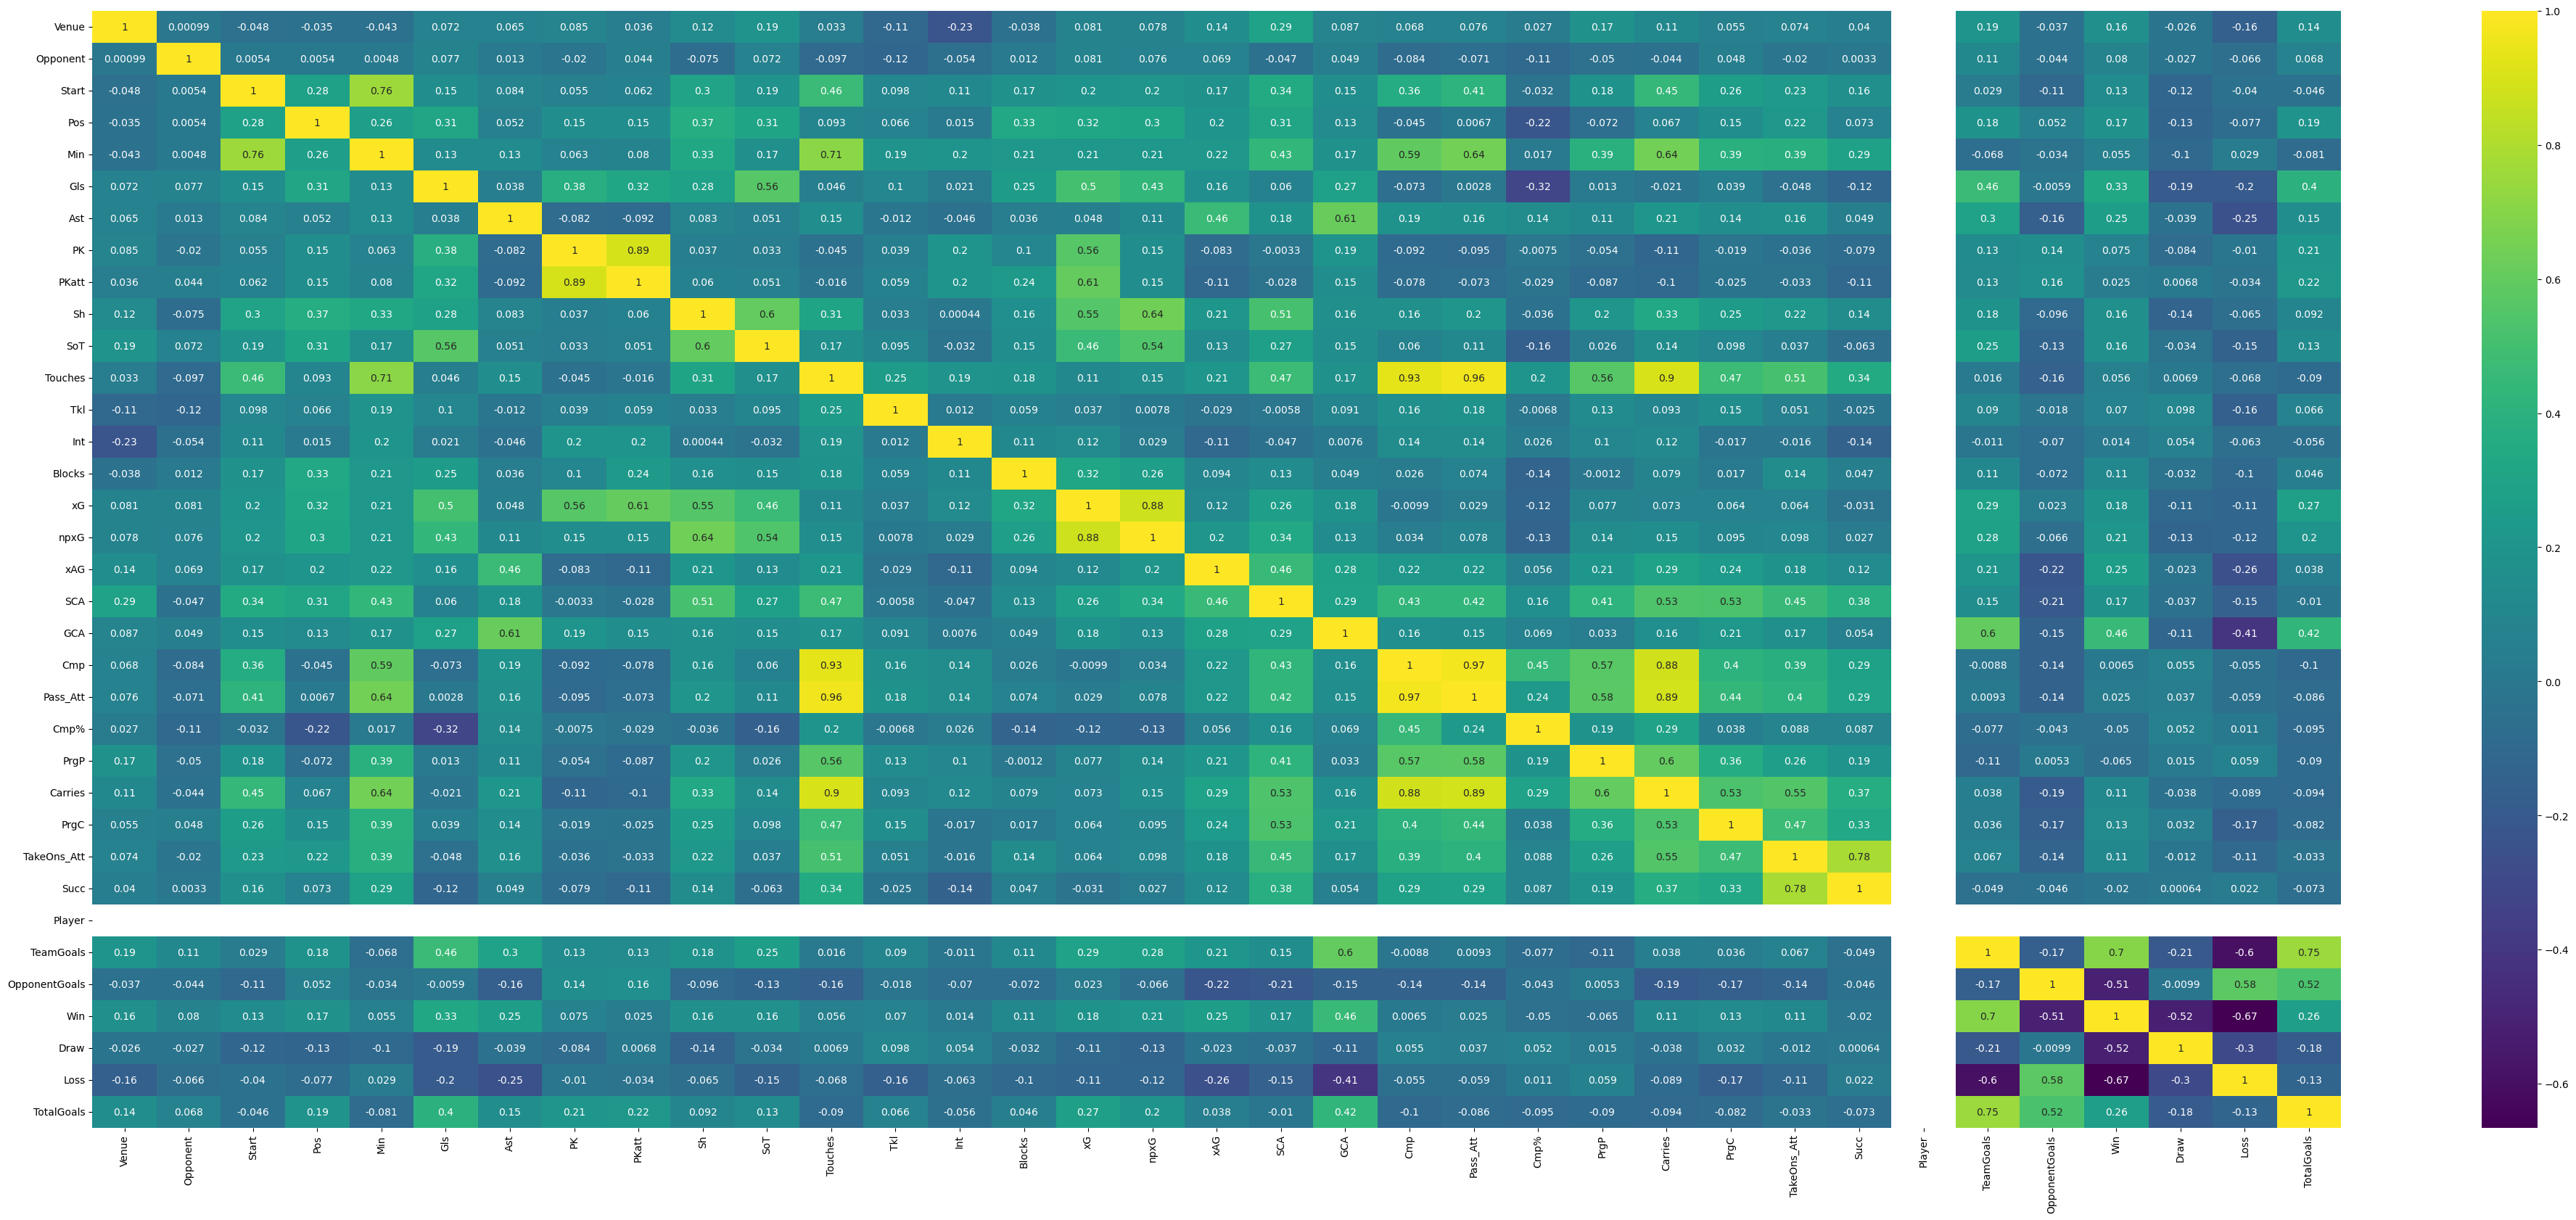

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = final_df.corr()
plt.figure(figsize=(50,20))
sns.heatmap(correlation_matrix, annot = True, cmap = 'viridis')

plt.show()

KeyboardInterrupt: 

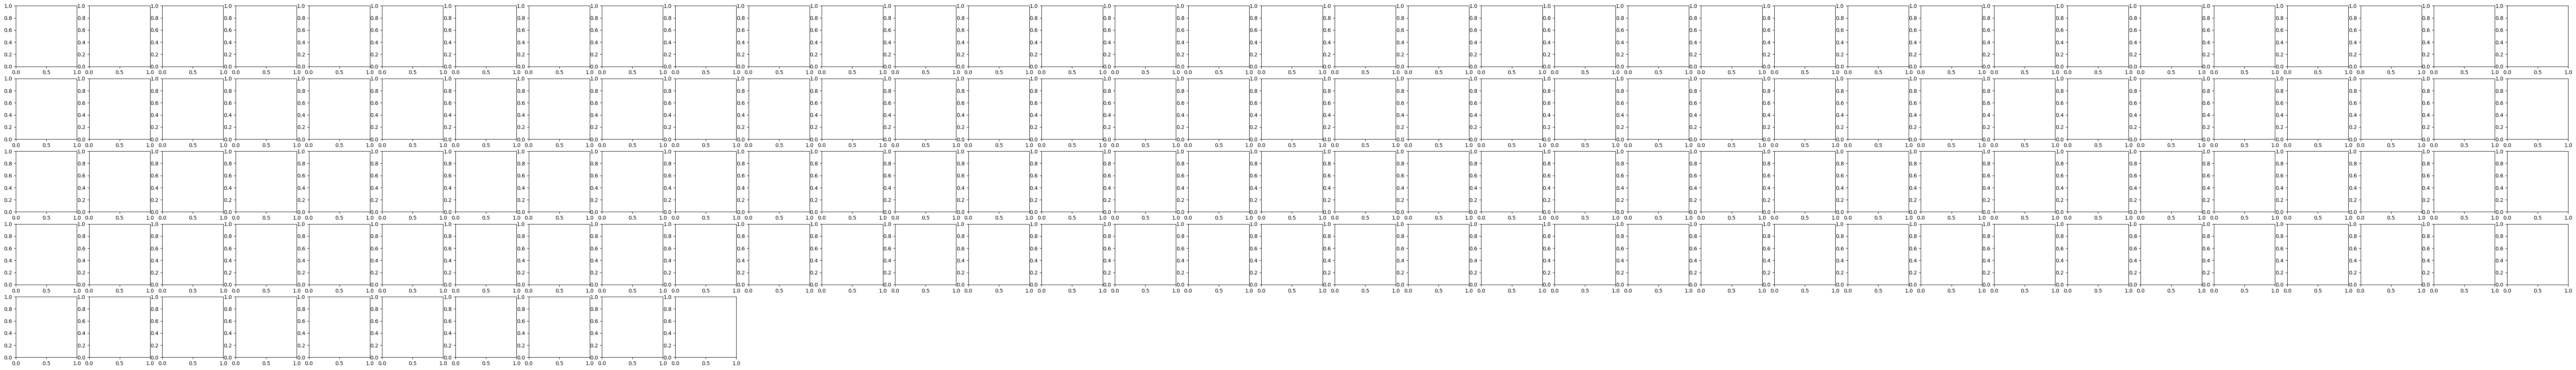

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

#Generating a Pairplot
sns.pairplot(final_df)
plt.show()


In [26]:
import numpy as np

a = np.array(
    [
    [1],
    [2],
    [3]
    ]
             )
b = np.array(
    [
        [4],
        [5],
        [6]
        ]
    )

c = np.hstack((a,b))

m = 5
np.size(c)

6

In [ ]:
c[[1,2]]  = c[[2,1]]

In [ ]:
c

array([[1, 4],
       [3, 6],
       [2, 5]])